# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

In [4]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

VLM_NAME = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

vlm = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
vlm.language_model.generation_config.temperature = None
vlm.language_model.generation_config.top_p = None
vlm.language_model.generation_config.do_sample = False

vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:104: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [59]:
from PIL import Image

from travel.data.vqa import VQG2VQA_PROMPT_TEMPLATES, get_vqa_response_token_ids

questions = ["Do you see the tap in the image?", 
             "Do you see the tap in the image?", 
             "Is there lettuce on the stove?",
             "Look at the stove. Is there lettuce on the stove?",
             "Is the tap turned on?",
            "Are there cherry tomatoes in the bowl?",
            "Look in the bowl. Are there any cherry tomatoes in the bowl?",
            "Are there cherry tomatoes in the bowl?",
            "Look in the bowl. Are there any cherry tomatoes in the bowl?",]
frames = [Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
         Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
         Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
          Image.open("demo_images/demo_frame0.png").convert("RGB"),
          Image.open("demo_images/demo_frame0.png").convert("RGB"),
          Image.open("demo_images/demo_frame2.png").convert("RGB"),
          Image.open("demo_images/demo_frame2.png").convert("RGB"),
         ]
prompts = [VQG2VQA_PROMPT_TEMPLATES[type(vlm)].format(question=question) for question in questions]

response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

In [60]:
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAOutputs, VQAResponse
from travel.model.vqa import run_vqa

result = run_vqa(vlm, vlm_processor, prompts, frames, batch_size=10)
result = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result[i]) for i in range(result.shape[0])]

running VQA (cuda:0): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


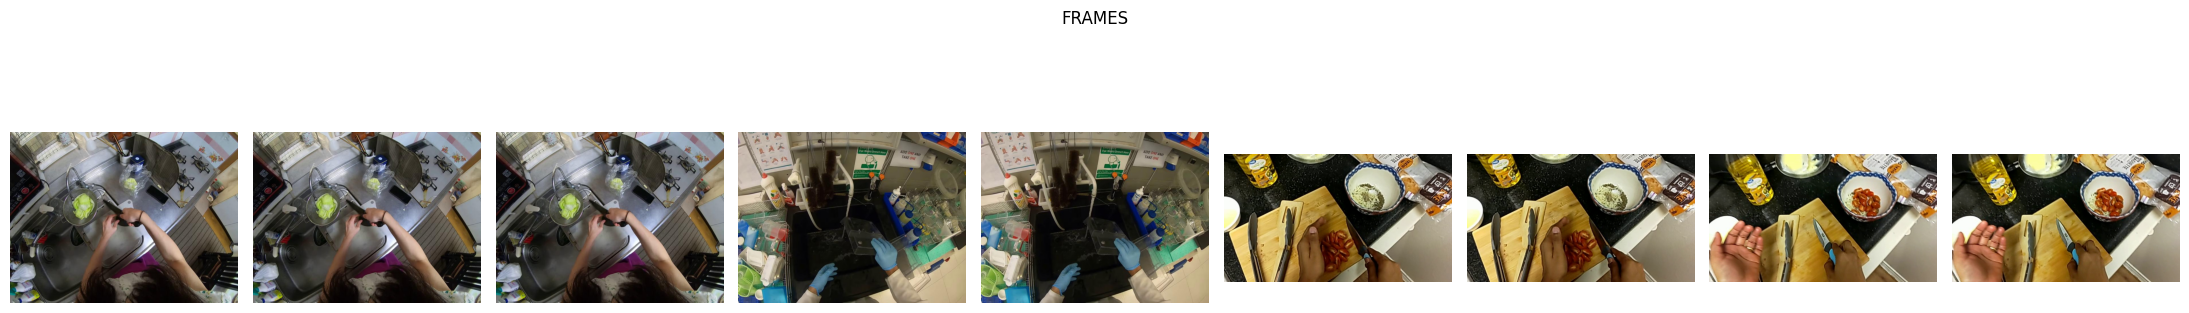

Do you see the tap in the image?
{<VQAResponse.No: 0>: 0.02178117, <VQAResponse.Yes: 1>: 0.97821885}

Do you see the tap in the image?
{<VQAResponse.No: 0>: 0.02178117, <VQAResponse.Yes: 1>: 0.97821885}

Is there lettuce on the stove?
{<VQAResponse.No: 0>: 0.036220055, <VQAResponse.Yes: 1>: 0.96378}

Look at the stove. Is there lettuce on the stove?
{<VQAResponse.No: 0>: 0.87914675, <VQAResponse.Yes: 1>: 0.12085323}

Is the tap turned on?
{<VQAResponse.No: 0>: 0.35936415, <VQAResponse.Yes: 1>: 0.6406359}

Are there cherry tomatoes in the bowl?
{<VQAResponse.No: 0>: 0.09334688, <VQAResponse.Yes: 1>: 0.90665317}

Look in the bowl. Are there any cherry tomatoes in the bowl?
{<VQAResponse.No: 0>: 0.028220987, <VQAResponse.Yes: 1>: 0.971779}

Are there cherry tomatoes in the bowl?
{<VQAResponse.No: 0>: 0.020645931, <VQAResponse.Yes: 1>: 0.979354}

Look in the bowl. Are there any cherry tomatoes in the bowl?
{<VQAResponse.No: 0>: 0.001622967, <VQAResponse.Yes: 1>: 0.99837697}



In [61]:
import matplotlib.pyplot as plt

# Assuming new_frames is a list of image data
fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
fig.suptitle("FRAMES")

# Ensure axarr is always iterable
if len(frames) == 1:
    axarr = [axarr]

for frame, ax in zip(frames, axarr):
    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

for q, r in zip(questions, result):
    print(q)
    pprint(r.answer_probs)
    print("")

In [ ]:
# Adapted from pipeline.py in WTaG code

from travel.wtag.util import *

def genAndCall(prompt_recipe, chat_history, timei, fill_user_asr=None, fill_inst_asr=None, \
									vb_generated_text=None, predicted_objects=None):
	prompt_i, prompt_obi = get_prompt(prompt_recipe, chat_history, timei, fill_user_asr=fill_user_asr, \
							fill_inst_asr=fill_inst_asr, vb_generated_text=vb_generated_text, \
							predicted_objects=predicted_objects)	
	time_last_say = timei
	print(prompt_obi)
	print("############ OUTPUT FROM API ########")

	# TODO: generate an answer using LLaVA
	text = "<placeholder returned text>"
	
	print(text)
	print()
	print()

	return time_last_say, prompt_i, text


def getInstruct(file_name, MTYPE, all_vid_path, out_path):
	############################################ import everything ############################################
	############################################ import everything ############################################

	### get recipe type
	recipe_type = file_name.split('_')[-1]
	print("### RECIPE: " + recipe_type)

	# import start and end time
	with open(os.path.join(all_vid_path, file_name, 'Video/VideoMpegTiming.txt')) as f:
		lines = f.readlines()
	vid_start = int(lines[0][:-1])
	vid_end = int(lines[1][:-1])
	print("Start/End Time:\t", vid_start, vid_end)

	# import steps
	in_step = []
	with open(os.path.join(all_vid_path, file_name,'StepDetection/StepDetection.txt')) as f:
		lines = f.readlines()
	for li in lines:
		tp = li[:-1].split('\t')
		tp[0] = int(tp[0])
		tp[1] = int(tp[1])
		in_step.append(tp)
	print("Num Steps:\t", len(in_step))


	# import instruct asr
	in_inst_asr = []
	with open(os.path.join(all_vid_path, file_name,'TextASR/InstructorAnnotations_intent.txt')) as f:
		lines = f.readlines()
	for li in lines:
		tp = li[:-1].split('\t')
		tp[0] = int(tp[0])
		tp[1] = int(tp[1])
		in_inst_asr.append(tp)
	print("Num Inst ASR:\t", len(in_inst_asr))
		
	# import user asr
	in_user_asr = []
	with open(os.path.join(all_vid_path, file_name,'TextASR/UserAnnotations_intent.txt')) as f:
		lines = f.readlines()
	for li in lines:
		tp = li[:-1].split('\t')
		tp[0] = int(tp[0])
		tp[1] = int(tp[1])
		in_user_asr.append(tp)
	print("Num User ASR:\t", len(in_user_asr))

	### import GT recipe
	recipe_name = os.path.join(name_li_path, "recipe_" + recipe_type + ".txt")
	prompt_recipe = ""
	with open(recipe_name) as f:
		lines = f.readlines()
	for li in lines:
		prompt_recipe += li


	### Import video
	video = VideoFileClip(os.path.join(all_vid_path, file_name,"Video/Video.mpeg"))
	audio = video.audio
	num_frames = int(video.fps * video.duration)
	frame_ratio = num_frames/(vid_end - vid_start)
	frames = video.iter_frames()

	print("duration\t", str(video.duration))
	print("num_frames\t", str(num_frames))
	print()


	############################################ Model Specific Prep ############################################
	############################################ Model Specific Prep ############################################
	
	### Prepare Obj Detection
	if MTYPE == 'objDet':
		model_obj1, model_cb, model_hand, objs_pinwheel_out, pinwheel_dic_clean = prep_obj(recipe_type)
		egoModels = [model_obj1, model_cb, model_hand]


	############################################ Going through Frames ############################################
	############################################ Going through Frames ############################################
	last_say_user = ""
	last_say_inst = ""
	time_last_say = 0
	chat_history = []
	obj_history = []
	obj_history_state_dic = {}


	### run detection model on each frame
	for i, fra in enumerate(frames):
		# remove before start and after end
		if (in_step[0][2] == 'Start') and (i <= (in_step[0][1] - vid_start)*frame_ratio):
			continue
		if (in_step[-1][2] == 'Done') and (i >= (in_step[-1][0] - vid_start)*frame_ratio):
			break
		timei = round(i/frame_ratio/1e7, 1)
		prompt_i = ""
		vb_generated_text = None
		predicted_objects = None
		prompt_type3 = None

		# everytime inst talks
		say_ins = parse_text_time(i, in_inst_asr, vid_start, frame_ratio)
		if (len(say_ins) != 0) and (say_ins[0] != last_say_inst):
			prompt_type3 = "##### INSTRUCTOR PROMPT: " + str(i) +  '/' + str(num_frames)
			print(prompt_type3)
			last_say_inst = say_ins[0]
			if MTYPE == 'objDet':
				predicted_objects, obj_history, obj_history_state_dic = get_obj_states(fra, obj_history, \
									obj_history_state_dic, egoModels, objs_pinwheel_out, pinwheel_dic_clean)
			elif MTYPE == 'blip2':
				vb_generated_text = call_BLIP2(fra)
			time_last_say, prompt_i, text = genAndCall(prompt_recipe, chat_history, timei, fill_user_asr=None, \
										fill_inst_asr=last_say_inst, vb_generated_text=vb_generated_text, \
										predicted_objects=predicted_objects)
			chat_history.append([timei, "You", last_say_inst])

		
		# everytime user talks
		say_usr = parse_text_time(i, in_user_asr, vid_start, frame_ratio)
		if (len(say_usr) != 0) and (say_usr[0] != last_say_user):			
			prompt_type3 = "##### USER PROMPT: " + str(i) + '/' + str(num_frames)
			print(prompt_type3)
			last_say_user = say_usr[0]
			if MTYPE == 'objDet':
				predicted_objects, obj_history, obj_history_state_dic = get_obj_states(fra, obj_history, \
									obj_history_state_dic, egoModels, objs_pinwheel_out, pinwheel_dic_clean)
			elif MTYPE == 'blip2':
				vb_generated_text = call_BLIP2(fra)
			time_last_say, prompt_i, text = genAndCall(prompt_recipe, chat_history, timei, fill_user_asr=last_say_user, \
									fill_inst_asr=None, vb_generated_text=vb_generated_text, \
									predicted_objects=predicted_objects)
			chat_history.append([timei, "User", last_say_user])

		
			# not talking for wait time
		if (prompt_i == "") and ((i/frame_ratio/1e7 - time_last_say) > time_wait):
			prompt_type3 = "##### WAIT PROMPT: " + str(i) + '/' + str(num_frames)
			print(prompt_type3)
			if MTYPE == 'objDet':
				predicted_objects, obj_history, obj_history_state_dic = get_obj_states(fra, obj_history, \
									obj_history_state_dic, egoModels, objs_pinwheel_out, pinwheel_dic_clean)
			elif MTYPE == 'blip2':
				vb_generated_text = call_BLIP2(fra)
			time_last_say, prompt_i, text = genAndCall(prompt_recipe, chat_history, timei, fill_user_asr=None, \
									fill_inst_asr=None, vb_generated_text=vb_generated_text, \
									predicted_objects=predicted_objects)


		# write prompts to file
		if prompt_i != "":
			with open(os.path.join(out_path, "prompt_" + file_name + ".txt"), "a") as file1:
				file1.writelines("##### FRAME: " + str(i) + '/' + str(num_frames) + '\n')
				file1.writelines(prompt_i)

			with open(os.path.join(out_path, "api_" + file_name + ".txt"), "a") as file2:
				file2.writelines("\n\n" + prompt_type3)
				file2.writelines("\n##### FRAME: " + str(i) + '/' + str(num_frames) + '\n')
				file2.writelines(text)

In [ ]:
def main(MTYPE, video_list, in_path, out_path):
	# open a list of file names
	with open(video_list) as f:
		lines = f.readlines()

		# go through each recording one by onne
		for li in lines:
			print(li[:-1])
			getInstruct(li[:-1], MTYPE, in_path, out_path)

main("lanOnly", "")